In [44]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Subset, Dataset
from PIL import Image, ImageDraw
from torchvision import datasets, transforms, models
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
from zennit.composites import EpsilonPlusFlat
from zennit.canonizers import SequentialMergeBatchNorm
from crp.attribution import CondAttribution
from crp.helper import get_layer_names
from crp.concepts import ChannelConcept
import matplotlib.pyplot as plt

Here is an overview of the experiment:

Use augmented model as base. Evaluate performance on the same augmented test set, normal MNIST, and domain shifted MNIST

Find most misclassified samples from the tests especially the domain shifted MNIST

Evaluate consistent and inconsistent channels for these predictions

Use CRP to visualize some of these and use RelMax as well. See if we can discover the augmentation

Turn off channels deemed inconsistent and view the results as well as other nuanced approaches

Also use normal MNIST model as baseline

First let's setup the proper test sets and models.

In [45]:
# class model was trained on
class AddWhiteSquareToThree:
    def __init__(self, square_size=4):
        self.square_size = square_size

    def __call__(self, img, target):
        if target == 3:  # Check if the image is a digit '3'
            if random.random() > 0:
                draw = ImageDraw.Draw(img)
                draw.rectangle([(2, 2), (self.square_size, self.square_size)], fill="white")
        return img
    
# domain shifted class
class AddWhiteSquareToSomeDS:
    def __init__(self, square_size=4):
        self.square_size = square_size

    def __call__(self, img, target):
        if target == 2:  
            if random.random() > 0:
                draw = ImageDraw.Draw(img)
                draw.rectangle([(2, 2), (self.square_size, self.square_size)], fill="white")
        elif target == 5:
            if random.random() > 0:
                draw = ImageDraw.Draw(img)
                draw.rectangle([(2, 2), (self.square_size, self.square_size)], fill="white")
        elif target == 7:
            if random.random() > 0:
                draw = ImageDraw.Draw(img)
                draw.rectangle([(2, 2), (self.square_size, self.square_size)], fill="white")
        return img, target

class CustomMNISTAug(Dataset):
    def __init__(self, mnist_dataset, transform=None):
        self.mnist_dataset = mnist_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        img, target = self.mnist_dataset[idx]
        img = AddWhiteSquareToThree()(img, target)
        if self.transform:
            img = self.transform(img)
        return img, target
    
class CustomMNISTAugDS(Dataset):
    def __init__(self, mnist_dataset, transform=None):
        self.mnist_dataset = mnist_dataset
        self.transform = transform

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        img, target = self.mnist_dataset[idx]
        img, target = AddWhiteSquareToSomeDS()(img, target)
        if self.transform:
            img = self.transform(img)
        return img, target

# if GPU is available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transform the MNIST images to 224x224 with three channels
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# setup datasets 

original_test_dataset = datasets.MNIST(root='./data', train=False, download=True)

test_dataset_aug = CustomMNISTAug(original_test_dataset, transform=transform)

test_dataset_ds = CustomMNISTAugDS(original_test_dataset, transform=transform)

test_dataset_normal = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

test_subset_size = 800   # Number of testing samples

test_indices = np.random.choice(len(test_dataset_aug), test_subset_size, replace=False)

# Create subsets

test_dataset_aug = Subset(test_dataset_aug, test_indices)

test_dataset_ds = Subset(test_dataset_ds, test_indices)

test_dataset_normal = Subset(test_dataset_normal, test_indices)

# Data loaders
test_loader_aug = DataLoader(dataset=test_dataset_aug, batch_size=64, shuffle=False)
test_loader_ds = DataLoader(dataset=test_dataset_ds, batch_size=64, shuffle=False)
test_loader_normal = DataLoader(dataset=test_dataset_normal, batch_size=64, shuffle=False)

print("Datasets are ready for training.")

Datasets are ready for training.


In [116]:
# load model
aug_model = models.vgg16(pretrained=True)
aug_model.classifier[6] = nn.Linear(aug_model.classifier[6].in_features, 10)
aug_model.load_state_dict(torch.load('mnist_vgg16_custom_with_white_square.pth'))
aug_model.eval()

/Users/reedandreas/Desktop/academic/CS CPS/final_project/utils3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/reedandreas/Desktop/academic/CS CPS/final_project/utils3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [47]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    wrong_predictions = {}
    for i in range(10):
        temp = {}
        for j in range(10):
            temp[j] = 0
        wrong_predictions[i] = temp

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # keep track of which digits were misclassified
            for i in range(len(labels)):
                if predicted[i] != labels[i]:
                    wrong_predictions[labels[i].item()][predicted[i].item()] += 1
                    
    return (100 * correct / total, wrong_predictions)

Now we are going to evaluate the performance of the normal MNIST model and the augmented MNIST model on the augmented test set, normal MNIST, and domain shifted MNIST.

In [101]:
original_aug_res, original_aug_dict = evaluate_model(aug_model, test_loader_aug) # we will save these for later
print("Augmented Augmented Accuracy: ", original_aug_res)
for i in range(10):
    print(i, original_aug_dict[i])

100%|██████████| 13/13 [01:01<00:00,  4.77s/it]

Augmented Augmented Accuracy:  91.75
0 {0: 0, 1: 1, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 3, 9: 0}
1 {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 3, 9: 0}
2 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0}
3 {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
4 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 2, 7: 1, 8: 0, 9: 2}
5 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 9, 9: 0}
6 {0: 8, 1: 0, 2: 0, 3: 0, 4: 0, 5: 2, 6: 0, 7: 0, 8: 0, 9: 0}
7 {0: 0, 1: 0, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 4}
8 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 4, 6: 0, 7: 0, 8: 0, 9: 0}
9 {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 6, 6: 1, 7: 1, 8: 7, 9: 0}


In [49]:
original_ds_res, original_ds_dict = evaluate_model(aug_model, test_loader_ds) # we will save these for later
print("Original DS Accuracy: ", original_ds_res)
for i in range(10):
    print(i, original_ds_dict[i])

100%|██████████| 13/13 [00:51<00:00,  4.00s/it]

Original DS Accuracy:  64.5
0 {0: 0, 1: 1, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 3, 9: 0}
1 {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 3, 9: 0}
2 {0: 0, 1: 0, 2: 0, 3: 25, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
3 {0: 1, 1: 0, 2: 17, 3: 0, 4: 0, 5: 14, 6: 0, 7: 3, 8: 43, 9: 3}
4 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 2, 7: 1, 8: 0, 9: 2}
5 {0: 0, 1: 0, 2: 0, 3: 75, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
6 {0: 8, 1: 0, 2: 0, 3: 0, 4: 0, 5: 2, 6: 0, 7: 0, 8: 0, 9: 0}
7 {0: 0, 1: 0, 2: 0, 3: 57, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
8 {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 4, 6: 0, 7: 0, 8: 0, 9: 0}
9 {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 6, 6: 1, 7: 1, 8: 7, 9: 0}


In [50]:
evaluate_model(aug_model, test_loader_normal)

100%|██████████| 13/13 [00:52<00:00,  4.05s/it]


(81.75,
 {0: {0: 0, 1: 1, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 3, 9: 0},
  1: {0: 0, 1: 0, 2: 1, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 3, 9: 0},
  2: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 0},
  3: {0: 1, 1: 0, 2: 17, 3: 0, 4: 0, 5: 14, 6: 0, 7: 3, 8: 43, 9: 3},
  4: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 2, 7: 1, 8: 0, 9: 2},
  5: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 0, 8: 9, 9: 0},
  6: {0: 8, 1: 0, 2: 0, 3: 0, 4: 0, 5: 2, 6: 0, 7: 0, 8: 0, 9: 0},
  7: {0: 0, 1: 0, 2: 2, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 1, 9: 4},
  8: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 4, 6: 0, 7: 0, 8: 0, 9: 0},
  9: {0: 1, 1: 0, 2: 0, 3: 0, 4: 1, 5: 6, 6: 1, 7: 1, 8: 7, 9: 0}})

Notice how performance is best on the augmented test set, then normal MNIST, and finally much worse on the domain shifted MNIST. This is expected as the model was trained on augmented data. In particular, take note of the poor performance in overguessing 3s. This is because the augmented test set had a white square in the top left on the 3s during training but the domain shifted MNIST instead has a white square in the top left of other digits (2, 5, 7). This simulates a possible scenario of a domain shifted feature affecting model performance. Our goal now is to use our approach to identify the feature and mitigate its effect on the model.

Let's setup CRP and RelMax

In [51]:
cc = ChannelConcept()
composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
attribution = CondAttribution(aug_model, no_param_grad=True)

In [52]:
def get_channel_importance(model, sample, condition):
    # Define the composite function and the attribution method
    composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
    attribution = CondAttribution(model, no_param_grad=True)

    # Ensure sample requires gradient
    sample.requires_grad = True

    # Setup conditions for the attribution
    conditions = [{"y": condition}]  # Condition y is the class index or other condition

    # Get the names of layers we are interested in (Conv2d and Linear for example)
    layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])

    # Use a dictionary for mask_map if needed
    mask_map = {}  # Assuming `True` enables the mask for all layers, adjust if needed

    # Perform the attribution
    attr = attribution(sample, conditions, composite, mask_map=mask_map, record_layer=layer_names)

    rel_c = cc.attribute(attr.relevances['features.28'], abs_norm=True)

    # Extract the top 'k' channels' relevance and their IDs using torch.topk
    k = 512  # Number of top channels to retrieve
    rel_values, concept_ids = torch.topk(rel_c[0], k)

    # Convert to percentage contributions
    rel_values_percent = rel_values * 100

    # Create a dictionary from concept_ids to their relative importance
    importance_dict = {int(cid): float(rv) for cid, rv in zip(concept_ids, rel_values_percent)}

    return importance_dict

In [53]:
def get_average_channel_importance(model, samples, condition):
    # Initialize a dictionary to sum importance scores
    total_importances = {}

    for sample in samples:
        # Get the channel importances for each sample
        importances = get_channel_importance(model, sample, condition)

        # Sum up the importance scores
        for channel, importance in importances.items():
            if channel in total_importances:
                total_importances[channel] += importance
            else:
                total_importances[channel] = importance

    # Calculate the average importance for each channel
    average_importances = {channel: total / len(samples) for channel, total in total_importances.items()}

    # Sort the channels by their average importance in descending order
    average_importances = dict(sorted(average_importances.items(), key=lambda item: item[1], reverse=True))

    return average_importances

In [54]:
def compare_channel_importance(model, set1_samples, set2_samples, condition):
    """
    Compare the average channel importance between two sets of samples, specifically focusing on absolute and relative differences (unsigned)
    :param model: The model to evaluate
    :param set1_samples: Samples from the first set
    :param set2_samples: Samples from the second set
    :param condition: The condition to evaluate
    """

    # Get average channel importances for both sets
    avg_importances_set1 = get_average_channel_importance(model, set1_samples, condition)
    avg_importances_set2 = get_average_channel_importance(model, set2_samples, condition)


    all_channels = set(avg_importances_set1.keys()).union(set(avg_importances_set2.keys()))
    absolute_differences = {}
    relative_differences = {}

    for channel in all_channels:
        importance_set1 = avg_importances_set1.get(channel, 0) 
        importance_set2 = avg_importances_set2.get(channel, 0)

        # Calculate absolute and relative differences
        abs_diff = abs(importance_set1 - importance_set2)
        if importance_set1 + importance_set2 > 0.05:  
            rel_diff = abs_diff / ((importance_set1 + importance_set2) / 2)
        else:
            rel_diff = 0

        absolute_differences[channel] = abs_diff
        relative_differences[channel] = rel_diff

    # Sort dictionaries by their values in descending order
    sorted_absolute_differences = dict(sorted(absolute_differences.items(), key=lambda item: item[1], reverse=True))
    sorted_relative_differences = dict(sorted(relative_differences.items(), key=lambda item: item[1], reverse=True))

    # Final score is 0.2 * absolute + relative
    final_score = {}
    for channel in sorted_absolute_differences:
        final_score[channel] = 0.2 * sorted_absolute_differences[channel] + sorted_relative_differences[channel]

    # keep the top 12
    final_score = dict(sorted(final_score.items(), key=lambda item: item[1], reverse=True)[:12])

    return final_score

In [55]:
def compare_channel_importance_harmonic(model, set1_samples, set2_samples, condition):
    """
    Uncover channel usage differences between two sets of samples using harmonic mean to see where the model is using the channels differently
    :param model: The model to evaluate
    :param set1_samples: Samples from the first set
    :param set2_samples: Samples from the second set
    :param condition: The condition to evaluate
    """

    # Get average channel importances for both sets
    avg_importances_set1 = get_average_channel_importance(model, set1_samples, condition)
    avg_importances_set2 = get_average_channel_importance(model, set2_samples, condition)


    all_channels = set(avg_importances_set1.keys()).union(set(avg_importances_set2.keys()))
    usage_differences = {}

    # Calculate absolute usage differences and filter based on key criteria
    for channel in all_channels:
        importance_set1 = avg_importances_set1.get(channel, 0)
        importance_set2 = avg_importances_set2.get(channel, 0)

        # get maximal usage
        max_usage = max(importance_set1, importance_set2)

        if max_usage < 0.02: # Ignore channels with low usage
            continue

        min_usage = min(abs(importance_set1), abs(importance_set2))

        max_usage_score = max_usage # Reward high usage in one of the sets
        min_usage_score = 1/min_usage if min_usage > 0 else 50 # Reward low usage in one of the sets

        min_usage_score = min_usage_score if min_usage_score < 50 else 50

        # Harmonic mean
        usage_differences[channel] = 2 * (max_usage_score * min_usage_score) / (max_usage_score + min_usage_score)

    # Sort the usage differences and return
    sorted_usage_differences = dict(sorted(usage_differences.items(), key=lambda item: item[1], reverse=True))

    return sorted_usage_differences


Let's find some fives and threes (heavily misclassified) from both augmented and domain shifted MNIST

In [56]:
# find all the 3s in the test_loader_ds and save them in a list
threes = []
for i in range(len(test_dataset_ds)):
    temp = test_dataset_ds[i][0].unsqueeze(0).to(device)
    target = test_dataset_ds[i][1]
    if target == 3:
        threes.append(temp)
    if len(threes) == 40:
        break

# find all the 3s in the test_loader_aug
threes_aug = []
for i in range(len(test_dataset_aug)):
    temp = test_dataset_aug[i][0].unsqueeze(0).to(device)
    target = test_dataset_aug[i][1]
    if target == 3:
        threes_aug.append(temp)
    if len(threes_aug) == 40:
        break

In [57]:
# find all 5s in the test_loader_ds and save them in a list
fives = []
for i in range(len(test_dataset_ds)):
    temp = test_dataset_ds[i][0].unsqueeze(0).to(device)
    target = test_dataset_ds[i][1]
    if target == 5:
        fives.append(temp)
    if len(fives) == 40:
        break

# find all 5s in the test_loader_aug
fives_aug = []
for i in range(len(test_dataset_aug)):
    temp = test_dataset_aug[i][0].unsqueeze(0).to(device)
    target = test_dataset_aug[i][1]
    if target == 5:
        fives_aug.append(temp)
    if len(fives_aug) == 40:
        break

In [58]:
def compare_channel_importance_signed(model, set1_samples, set2_samples, condition):
    """
    Compare the average channel importance between two sets of samples, specifically focusing on signed and relative differences
    :param model: The model to evaluate
    :param set1_samples: Samples from the first set
    :param set2_samples: Samples from the second set
    :param condition: The condition to evaluate
    """

    # Get average channel importances for both sets
    avg_importances_set1 = get_average_channel_importance(model, set1_samples, condition)
    avg_importances_set2 = get_average_channel_importance(model, set2_samples, condition)
    all_channels = set(avg_importances_set1.keys()).union(set(avg_importances_set2.keys()))

    # Initialize dictionaries to hold differences and scores
    signed_differences = {}
    relative_differences = {}
    final_scores = {}

    # Calculate differences for each channel
    for channel in all_channels:
        importance_set1 = avg_importances_set1.get(channel, 0)  # Default to 0 if not present
        importance_set2 = avg_importances_set2.get(channel, 0)

        signed_diff = importance_set1 - importance_set2
        abs_diff = abs(signed_diff)

        # Calculate relative difference
        if importance_set1 + importance_set2 > .05:  # Both avoid division by zero and make sure these are important enough to consider
            rel_diff = abs_diff / ((importance_set1 + importance_set2) / 2)
        else:
            rel_diff = 0

        # Align the sign of relative difference with the signed difference
        rel_diff *= (-1 if signed_diff < 0 else 1)
        
        signed_differences[channel] = signed_diff
        relative_differences[channel] = rel_diff

        # Final score is 0.2 * absolute + relative
        final_scores[channel] = 0.2 * signed_diff + rel_diff

    # Separate and sort channels based on their scores
    positive_scores = {k: v for k, v in final_scores.items() if v >= 0}
    negative_scores = {k: v for k, v in final_scores.items() if v < 0}

    sorted_positive_scores = dict(sorted(positive_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_negative_scores = dict(sorted(negative_scores.items(), key=lambda item: item[1]))

    # keep the top 5 positive and negative scores
    sorted_positive_scores = dict(list(sorted_positive_scores.items())[:5])
    sorted_negative_scores = dict(list(sorted_negative_scores.items())[:5])

    return sorted_positive_scores, sorted_negative_scores

We can compare their channel importances below

In [59]:
compare_channel_importance(aug_model, threes, threes_aug, 3)

{35: 14.894087135791779,
 215: 7.542676105499268,
 11: 4.5639885067355825,
 508: 3.0864349031044824,
 434: 1.8056442006677391,
 80: 1.5324882187585078,
 471: 0.19701555691659453,
 210: 0.14610062122344972,
 436: 0.08235611056908965,
 465: 0.002788470312952996,
 479: 0.002255938526232058,
 251: 3.03662576698116e-06}

In [60]:
compare_channel_importance_signed(aug_model, threes, threes_aug, 3)

({0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0},
 {35: -14.894087135791779,
  215: -7.542676105499268,
  11: -4.5639885067355825,
  508: -3.0864349031044824,
  434: -1.8056442006677391})

In [61]:
compare_channel_importance_harmonic(aug_model, threes, threes_aug, 3)

{80: 1.4546905283382823,
 11: 0.5199126762464327,
 434: 0.48915728726298846,
 471: 0.4723320973469937,
 508: 0.2086336723641036,
 215: 0.13578395478838798,
 35: 0.06037420469861491}

Depending on your results, you should have noticed in particular channels 80 and 11 (in harmonic comparison) as being very suspect for inconsistent behavior.

In [62]:
def visualize_channel_heatmaps(model, sample, condition, channels):
    composite = EpsilonPlusFlat([SequentialMergeBatchNorm()])
    attribution = CondAttribution(model, no_param_grad=True)
    
    sample.requires_grad = True
    conditions = [{"y": condition}]
    layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])
    mask_map = {name: True for name in layer_names}

    attr = attribution(sample, conditions, composite, mask_map=mask_map, record_layer=layer_names)
    rel_c = cc.attribute(attr.relevances['features.28'], abs_norm=True)
    
    rel_values = torch.tensor([rel_c[0][channel] for channel in channels])
    concept_ids = torch.tensor(channels)

    # sort both rel_values and concept_ids the same way in descending order based on rel_values
    rel_values, indices = torch.sort(rel_values, descending=True)
    concept_ids = concept_ids[indices]

    rel_values_percent = rel_values * 100

    conditions = [{'features.28': [int(cid)], 'y': [condition]} for cid in concept_ids]
    heatmap, _, _, _ = attribution(sample, conditions, composite)

    # Assuming heatmap is a torch tensor or a compatible numpy array
    fig, axs = plt.subplots(1, len(concept_ids), figsize=(15, 3))
    for i, ax in enumerate(axs):
        img = ax.imshow(heatmap[i].detach().numpy(), cmap='viridis')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Channel {concept_ids[i]}: {rel_values_percent[i]:.2f}%")
    plt.colorbar(img, ax=axs[-1], fraction=0.046, pad=0.04)  # Add a colorbar
    plt.show()
    
    return heatmap

In [63]:
augmented_three = Image.open('selected_augmented_3.png')
augmented_three = transform(augmented_three).unsqueeze(0).to(device)

normal_three = Image.open('selected_3.png')
normal_three = transform(normal_three).unsqueeze(0).to(device)

We will visualize these channels below

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

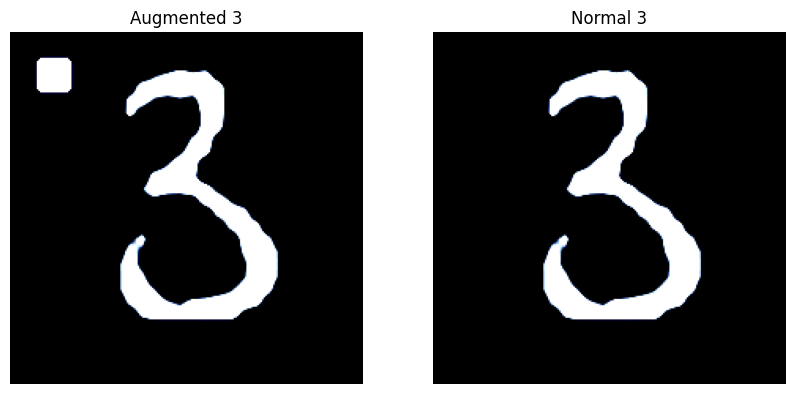

In [64]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(augmented_three.squeeze(0).cpu().permute(1, 2, 0))
plt.title('Augmented 3')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(normal_three.squeeze(0).cpu().permute(1, 2, 0))
plt.title('Normal 3')
plt.axis('off')

These are the main channels we saw potential for inconsistency in. It is now clear some of them are focusing on the white square in the top left of the digit. However, it is a bit difficult to see exactly what is going on.

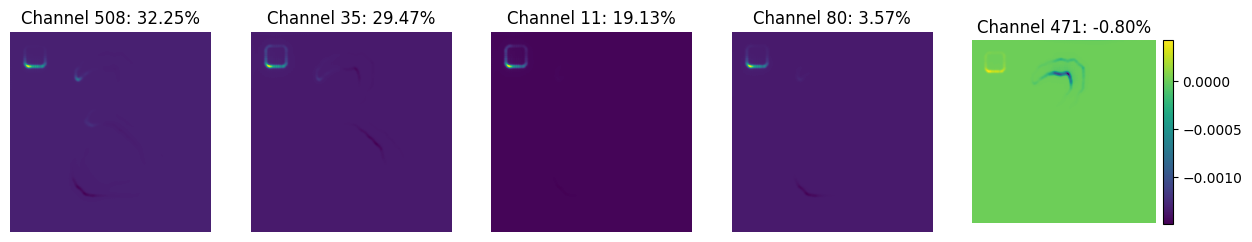

tensor([[[-4.7383e-06, -6.7770e-06, -6.5291e-06,  ...,  5.8518e-05,
           9.8294e-05,  7.8624e-05],
         [-5.3105e-06, -7.4306e-06, -6.8546e-06,  ...,  6.1783e-05,
           1.1694e-04,  9.6287e-05],
         [-2.4925e-06, -2.7978e-06, -1.2208e-06,  ...,  1.2363e-05,
           6.8813e-05,  6.4988e-05],
         ...,
         [ 5.2901e-06,  5.9738e-06,  2.7113e-06,  ..., -9.5804e-10,
          -4.9609e-09, -4.6448e-09],
         [ 1.2829e-05,  1.6417e-05,  1.6034e-05,  ..., -4.2055e-09,
          -8.1664e-09, -6.5025e-09],
         [ 1.1399e-05,  1.4781e-05,  1.5291e-05,  ..., -3.8684e-09,
          -6.5167e-09, -4.9583e-09]],

        [[ 3.7020e-04,  5.2895e-04,  5.0859e-04,  ..., -4.4394e-05,
          -7.4019e-05, -5.9036e-05],
         [ 4.1724e-04,  5.8261e-04,  5.3485e-04,  ..., -4.6860e-05,
          -8.8016e-05, -7.2289e-05],
         [ 2.1426e-04,  2.4042e-04,  1.0231e-04,  ..., -9.3376e-06,
          -5.1696e-05, -4.8794e-05],
         ...,
         [-2.8436e-12, -3

In [99]:
visualize_channel_heatmaps(aug_model, augmented_three, 3, [80, 11, 471, 508, 35])

Visualizing the same channels on the non-augmented model, we can see that the model is still using some channels like 508 while using others like 80 less. This is a good sign that we have discovered a domain shifted feature and we can try to mitigate after

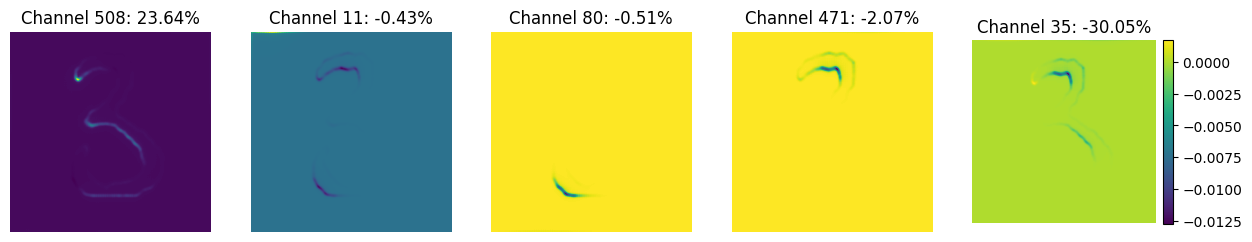

tensor([[[ 3.1487e-06,  4.4930e-06,  4.2701e-06,  ...,  2.7254e-05,
           4.5778e-05,  3.6617e-05],
         [ 3.5453e-06,  4.9454e-06,  4.4884e-06,  ...,  2.8775e-05,
           5.4462e-05,  4.4844e-05],
         [ 1.7978e-06,  2.0166e-06,  8.4851e-07,  ...,  5.7584e-06,
           3.2052e-05,  3.0270e-05],
         ...,
         [ 7.2349e-06,  8.1773e-06,  3.7758e-06,  ..., -1.8741e-10,
          -1.1782e-09, -1.1255e-09],
         [ 1.7544e-05,  2.2494e-05,  2.2339e-05,  ..., -7.0724e-10,
          -1.7666e-09, -1.5159e-09],
         [ 1.5586e-05,  2.0251e-05,  2.1304e-05,  ..., -6.3828e-10,
          -1.3717e-09, -1.1395e-09]],

        [[ 2.5068e-04,  3.5814e-04,  3.4283e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 2.8214e-04,  3.9404e-04,  3.6035e-04,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 1.4207e-04,  1.5942e-04,  6.7812e-05,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         ...,
         [-7.4325e-09, -8

In [100]:
visualize_channel_heatmaps(aug_model, normal_three, 3, [80, 11, 471, 508, 35])

In [67]:
augmented_five = Image.open('selected_domain_shifted_5.png')
augmented_five = transform(augmented_five).unsqueeze(0).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


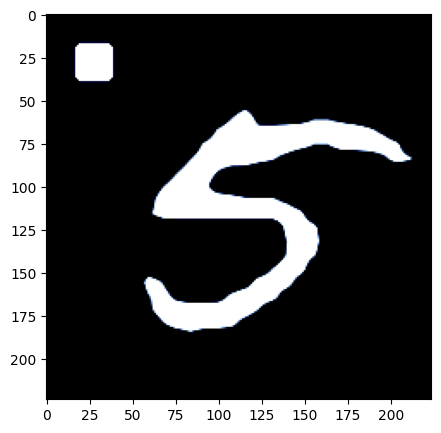

In [68]:
plt.figure(figsize=(5, 5))
plt.imshow(augmented_five.squeeze(0).cpu().permute(1, 2, 0))

In [117]:
augmented_five.requires_grad = True

outputs = aug_model(augmented_five)
_, predicted = torch.max(outputs.data, 1)

print(outputs, predicted)

tensor([[ -8.7762,  -6.0333,  -7.8051,  10.7252, -16.2217,   5.8184, -11.6023,
          -4.6652,   6.6424,  -6.2904]], grad_fn=<AddmmBackward0>) tensor([3])


Notice how we have a 5 that is being predicted as a 3. This is because the model is focusing on the white square in the top left of the digit. This is a domain shifted feature that we can try to mitigate.

In [118]:
mask_list = [11, 80]

def hook_function(module, input, output):
    # Set all activations in the masked channels to zero
    for i in range(len(mask_list)):
        output[:, mask_list[i], :, :] = 0  # Channel indexing is 0-based
    return output

hook = aug_model.features[28].register_forward_hook(hook_function)

Let's do a "light mask" approach where we turn off the channels we found to be most inconsistent and see if we can improve the model's performance on the domain shifted MNIST

In [119]:
outputs = aug_model(augmented_five)

hook.remove()

In [120]:
outputs

tensor([[ -6.6939,  -6.0056,  -7.1737,   5.4463, -15.5401,   7.3993,  -8.6733,
          -5.0517,   7.7367,  -6.5524]], grad_fn=<AddmmBackward0>)

Sure enough we see that it would now predict 5 rather than 3.

In [121]:
hook = aug_model.features[28].register_forward_hook(hook_function)

mild_hook_res, mild_hook_dict = evaluate_model(aug_model, test_loader_ds)

mild_hook_aug_res, mild_hook_aug_dict = evaluate_model(aug_model, test_loader_aug)

100%|██████████| 13/13 [00:50<00:00,  3.91s/it]


Evaluating the model on the augmented test set, we see that the model is still able to predict the augmented test set well but now our domain shifted MNIST performance has improved.

In [106]:
hook.remove()

In [107]:
mask_list = [11, 80, 471, 508, 215, 434]

def hook_function(module, input, output):
    # Set all activations in the masked channels to zero
    for i in range(len(mask_list)):
        output[:, mask_list[i], :, :] = 0  # Channel indexing is 0-based
    return output


Now we will try to mask even more of the inconsistent channels and see if we can further improve the model's performance on the domain shifted MNIST. However, we risk turning off channels that actually help the model predict the augmented test set.

In [108]:
hook = aug_model.features[28].register_forward_hook(hook_function)

moderate_hook_res, moderate_hook_dict = evaluate_model(aug_model, test_loader_ds)

moderate_hook_aug_res, moderate_hook_aug_dict = evaluate_model(aug_model, test_loader_aug)

100%|██████████| 13/13 [01:01<00:00,  4.71s/it]


In [109]:
hook.remove()

We can indeed see that the model is now degraded due to turning off too many channels. This is a tradeoff we must make when trying to mitigate domain shifted features.

In [110]:
def custom_evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    wrong_predictions = {}
    for i in range(10):
        temp = {}
        for j in range(10):
            temp[j] = 0
        wrong_predictions[i] = temp

    mask_list = [11, 80, 471, 508, 215, 434]

    def hook_function(module, input, output):
        # Set all activations in the masked channels to zero
        for i in mask_list:
            output[:, i, :, :] = 0
        return output

    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            for index in range(len(images)):
                single_image = images[index:index+1]  # Process one image at a time
                single_label = labels[index:index+1]
                
                # Perform initial inference
                output = model(single_image)
                _, predicted = torch.max(output.data, 1)
                prediction = predicted.item()
                label = single_label.item()
                
                if prediction == 3:
                    # Register hook if prediction is 3
                    hook = model.features[28].register_forward_hook(hook_function)
                    
                    # Rerun inference with the hook
                    rerun_output = model(single_image)
                    _, rerun_predicted = torch.max(rerun_output.data, 1)
                    rerun_prediction = rerun_predicted.item()
                    
                    # Evaluate rerun prediction
                    if rerun_prediction == label:
                        correct += 1
                    else:
                        wrong_predictions[label][rerun_prediction] += 1
                    
                    # Remove the hook
                    hook.remove()
                else:
                    # Evaluate initial prediction
                    if prediction == label:
                        correct += 1
                    else:
                        wrong_predictions[label][prediction] += 1
                
                total += 1

    accuracy = 100 * correct / total
    return accuracy, wrong_predictions

Our final strategy is a bit of a combination. We use the normal unmasked model for each prediction, but if we predict a "3", the problematic class, we recompute our prediction with the moderately masked model. This way we can still predict the augmented test set well but also mitigate the domain shifted feature in a particular class we know to be unreliable.

In [111]:
custom_eval_res, custom_eval_dict = custom_evaluate_model(aug_model, test_loader_ds, device)

custom_eval_aug_res, custom_eval_aug_dict = custom_evaluate_model(aug_model, test_loader_aug, device)

100%|██████████| 13/13 [00:51<00:00,  3.99s/it]


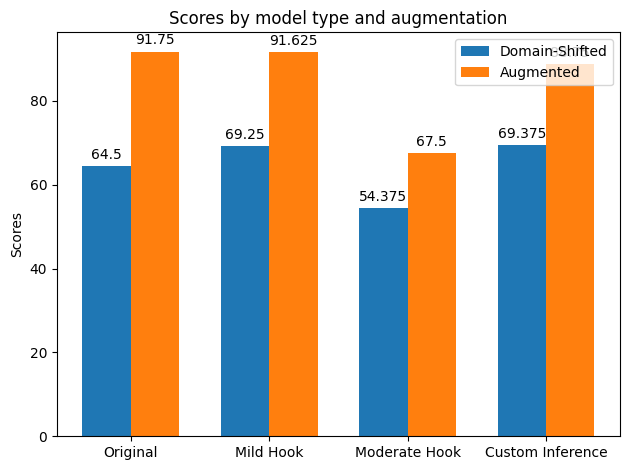

In [125]:
# plot accuracy in bar chart of original DS, mild hook, moderate hook, and custom evaluation
# add a second bar for each to show the accuracy on the augmented dataset
labels = ['Original', 'Mild Hook', 'Moderate Hook', 'Custom Inference']
original_ds = [original_ds_res, mild_hook_res, moderate_hook_res, custom_eval_res]
original_aug = [original_aug_res, mild_hook_aug_res, moderate_hook_aug_res, custom_eval_aug_res]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, original_ds, width, label='Domain-Shifted')
bars2 = ax.bar(x + width/2, original_aug, width, label='Augmented')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by model type and augmentation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Label with label_type annotation on the top of the bars
def autolabel(bars):
    """Attach a label_type above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

fig.tight_layout()

plt.show()